In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import sounddevice as sd
from scipy.io.wavfile import write
from scipy import signal

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE) 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import sounddevice as sd
from scipy.io.wavfile import write
from scipy import signal

c= 1
L= 1
dt = 0.001
tf = 2

dx = 0.01
dy = 0.01

t = np.arange(0, tf, dt)
x = np.arange(0, L+dx, dx)
y = np.arange(0, L+dy, dy)

xsize = len(x)
ysize = len(y)
tsize = len(t)


def membrane(cond_init, c, dt, dx, dy, tsize, bound):
    # Gauss eh o array com as condicoes iniciais
    # Função retorna um array com a solucao
    
    # Solucao
    sol = np.zeros((len(cond_init[0]), len(cond_init[1]), tsize))


    # Decidi normalizar a solucao para melhorar as visualizacoes
    sol[:,:,0] = cond_init/np.max(cond_init)
    
    if bound == 'quadrado':

        # Boundary Condition
        sol[0,:,:] = 0
        sol[-1,:,:] = 0
        sol[:,0,:] = 0
        sol[:,-1, :] = 0

        # Primeiro termo (t=1)
        sol[1:-1,1:-1,1] = (sol[1:-1, 1:-1,0] + (c**2/2)*(dt**2/dx**2)*(sol[1:-1,0:-2,0] - 2*sol[1:-1,1:-1,0] + sol[1:-1, 2:,0]) +
             (c**2/2)*(dt**2/dy**2)*(sol[0:-2,1:-1,0] - 2*sol[1:-1,1:-1,0] + sol[2:,1:-1,0]))

        # termos seguintes
        for t in range(2, tsize - 1):
            sol[1:-1,1:-1,t+1] = (2*sol[1:-1,1:-1,t] - sol[1:-1,1:-1,t-1] + (c**2)*((dt/dx)**2)*(sol[1:-1,0:-2,t]
                                - 2*sol[1:-1,1:-1,t] + sol[1:-1, 2:,t]) + (c**2)*((dt/dy)**2)*(sol[0:-2,1:-1,t] - 2*sol[1:-1,1:-1,t] + sol[2:, 1:-1,t]))

            sol[0,:,:] = 0
            sol[-1,:,:] = 0
            sol[:,0,:] = 0
            sol[:,-1, :] = 0
            
    elif bound == 'circulo':

        # Boundary Condition
        for i in range(len(sol[:,0,:])):
            for j in range(len(sol[0,:,:])):
                if (i - 50)**2 + (j - 50)**2 >= (len(sol[:,0,:])/2)**2:
                    sol[i,j,:] = 0

        # Primeiro termo (t=1)
        sol[1:-1,1:-1,1] = (sol[1:-1, 1:-1,0] + (c**2/2)*(dt**2/dx**2)*(sol[1:-1,0:-2,0] - 2*sol[1:-1,1:-1,0] + sol[1:-1, 2:,0]) +
             (c**2/2)*(dt**2/dy**2)*(sol[0:-2,1:-1,0] - 2*sol[1:-1,1:-1,0] + sol[2:,1:-1,0]))

        # Boundary Condition
        for i in range(len(sol[:,0,:])):
            for j in range(len(sol[0,:,:])):
                if (i - 50)**2 + (j - 50)**2 >= (len(sol[:,0,:])/2)**2:
                    sol[i,j,:] = 0

        # termos seguintes
        for t in range(1, tsize - 1):

            sol[1:-1,1:-1,t+1] = (2*sol[1:-1,1:-1,t] - sol[1:-1,1:-1,t-1] + (c**2)*((dt/dx)**2)*(sol[1:-1,0:-2,t]
                                - 2*sol[1:-1,1:-1,t] + sol[1:-1, 2:,t]) + (c**2)*((dt/dy)**2)*(sol[0:-2,1:-1,t] - 2*sol[1:-1,1:-1,t] + sol[2:, 1:-1,t]))

            # Boundary Condition
            for i in range(len(sol[:,0,:])):
                for j in range(len(sol[0,:,:])):
                    if (i - 50)**2 + (j - 50)**2 >= (len(sol[:,0,:])/2)**2:
                        sol[i,j,:] = 0
        
    else:
        print('Diga apenas (quadrado) ou (circulo)')
        return None
        
    return sol

# condicoes iniciais

X, Y = np.meshgrid(x, y)

# colocando X e Y em arrays 3d
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

#-----------------------------------------------------
# Primeira condicao inicial ( pulso gaussiano)

# matrix media e matrix de covariance
mu = np.array([0.5,0.5])
Sigma = np.array([[ .03 , 0], [0,  .03]])

def pulso_gaussiano2d(pos, mu, Sigma):

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # o metodo einsum calcula (x-mu)T.Sigma-1.(x-mu) como operacoes de matrices, arrays e tensores
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

gauss = pulso_gaussiano2d(pos, mu, Sigma)

#-----------------------------------------------------
# Segunda condicao inicial (modos normais)

nx = 35
ny = 35

def normal_modes(pos,nx,ny):
    solution = 10*(np.sin(nx*np.pi*(pos[:,:,0]))*np.cos(ny*np.pi*(pos[:,:,1]-0.5)))


    return solution

modes = normal_modes(pos,nx,y)



sol_gauss = membrane(gauss, c, dt, dx, dy, tsize, 'circulo')

sol_modes = membrane(modes, c, dt, dx, dy, tsize, 'quadrado')



## Initial Condition multivariate gaussian condition

## Visualizing the solution

/var/folders/mq/2x3nqx1s3m7_d6yf0m5rddsw0000gn/T/ipykernel_14233/2332012817.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


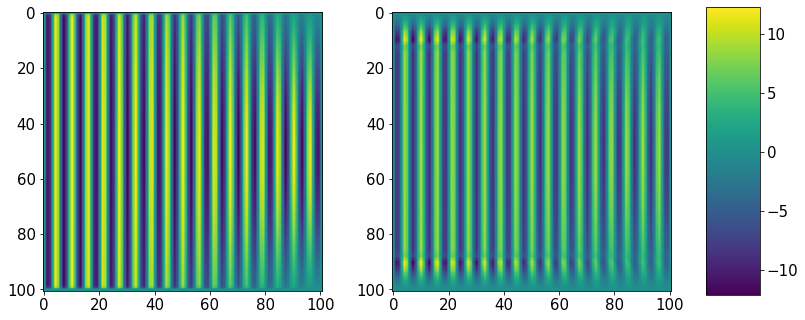

In [3]:
fig= plt.figure(figsize=(10,10))

plt.subplot(121)
plt.imshow(sol_modes[:,:,10])
#plt.colorbar(im1,fraction=0.046)

plt.subplot(122)
plt.imshow(sol_modes[:,:,200])
#plt.colorbar(im2,fraction=0.046)


plt.subplots_adjust(bottom=0.1, right=0.9, top=0.9)
cax = plt.axes([1, 0.3, 0.075, 0.4])
plt.colorbar(cax=cax)
plt.tight_layout()

#plt.savefig("heatmap_modos_normais_n=2.png",dpi=300, bbox_inches = "tight")

plt.show()

## Heatmap animation

.

NameError: name 'sol' is not defined

.Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fb758c9a280> (for post_execute):


NameError: name 'sol' is not defined

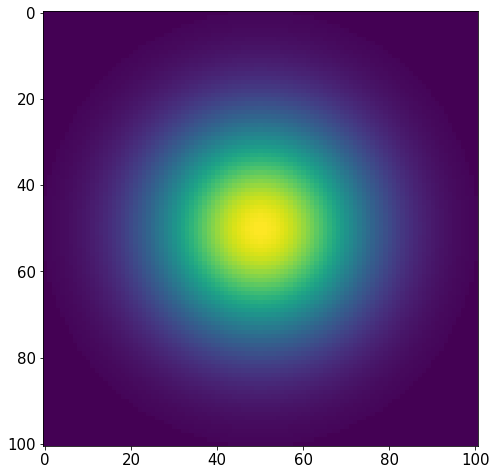

In [4]:
import matplotlib.pyplot as plt

import matplotlib.animation as animation


fps = 200
nSeconds = 3

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure( figsize=(8,8) )

im = plt.imshow(sol_gauss[:,:,0])

def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )

    im.set_array(sol[:,:,i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('test_anim_imshow.mp4', fps=fps)

print('Done!')

# plt.show()  # Not required, it seems!

### 3D plot

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))


im = ax.plot_surface(X,Y,sol_gauss[:,:,0],rstride=1, cstride=1,cmap=plt.cm.jet,linewidth=0,antialiased=False)
plt.colorbar(im,fraction=0.046, pad=0.04)


ax.set_zlim(-1, 1)
#plt.savefig("modos_retangular.png")
plt.show()

### 3D animation

In [ ]:


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

fps = 60
nSeconds = 10


plot = ax.plot_surface(X,Y,sol[:,:,0]/50,rstride=1, cstride=1,cmap=plt.cm.jet,linewidth=0,antialiased=False)
ax.set_zlim(-.5, .5)

t=0

def data_gen(framenumber, soln, plot):
    global t
    ax.clear()
    plot = ax.plot_surface(X,Y,sol[:,:,t]/50,rstride=1, cstride=1,cmap=plt.cm.jet,linewidth=0,antialiased=False)
    
    ax.set_zlim(-1, 1)

    t += 1
    return plot,


anim = animation.FuncAnimation(
                               fig, 
                               data_gen, 
                               frames = nSeconds * fps,
                                fargs=(sol, plot),
                               interval = 1000 / fps, # in ms
                               )
#plt.show(anim)
#anim.save('modos_retangular.mp4', fps=fps)


# Different initial conditions

### Initial condition 1


In [ ]:

X, Y = np.meshgrid(x, y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def other_function(pos):
    solution = 10*(np.sin(35*np.pi*(pos[:,:,0]))*np.cos(35*np.pi*(pos[:,:,1]-0.5)))
    #solution += (1/500)*(np.sin(3*np.pi*(pos[:,:,1]+ pos[:,:,0])) + 3*np.sin(11*np.pi*(pos[:,:,0]+ pos[:,:,1])))


    return solution

# The distribution on the variables X, Y packed into pos.
gauss = other_function(pos)
            
im = plt.imshow(gauss)
plt.colorbar(im,fraction=0.046, pad=0.04)



### Initial condition  2

### $$f(x) = \frac{1}{\sqrt{2\pi | \boldsymbol{{\Sigma} | }}}e^{\frac{-1}{2}(\boldsymbol{x} - \boldsymbol{\mu})^2\boldsymbol{\Sigma^{-1}}(\boldsymbol{x} -\boldsymbol{\mu})}$$

$\boldsymbol{x} = 2D-Vector$

$\boldsymbol\mu = \begin{bmatrix}
\mu_x\\ 
u_y
\end{bmatrix}$

 $\boldsymbol{\Sigma}=\begin{bmatrix}
 \sigma_x^2 &  \rho\sigma_x\sigma_y  \\
\rho\sigma_x\sigma_y &  \sigma_y^2
\end{bmatrix}$

In [ ]:
# Mean vector and covariance matrix
mu = np.array([0.5,0.5])
Sigma = np.array([[ .03 , 0], [0,  .03]])


X, Y = np.meshgrid(x, y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N
# The distribution on the variables X, Y packed into pos.
gauss = multivariate_gaussian(pos, mu, Sigma)

# plot using subplots
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,3,1,projection='3d')

ax1.plot_surface(X, Y, gauss, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cm.viridis)
ax1.view_init(55,-70)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')

ax2 = fig.add_subplot(2,1,1,projection='3d')
ax2.contourf(X, Y, gauss, zdir='z', offset=0, cmap=cm.viridis)
ax2.view_init(90, 270)

ax2.grid(False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_xlabel(r'$x_1$')
ax2.set_ylabel(r'$x_2$')

plt.show()

### Initial condition 3

In [ ]:
a = [2,4,6,10,12,18,22] 

X, Y = np.meshgrid(x, y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def f(a,pos):
    y = np.zeros(pos[:,:,0].shape)
    for n in range(len(a)):
        y  += a[n]*np.sin((n+1)*np.pi*(pos[:,:,0] - 0.5)) + a[n]*np.cos((n+1)*np.pi*(pos[:,:,1] -0.5))


    return y

gauss = f(a,pos)
            
im = plt.imshow(gauss)
plt.colorbar(im,fraction=0.046, pad=0.04)



# Generating the sound

In [ ]:
data = 0
for i in range(len(sol[:,0,0])):
    for j in range(len(sol[0,:,0])):
        data += sol[i,j,:]
    
audio = sd.play(sol_gauss[50,50,:]*10, int((tf/dt)))
#plt.plot(data)
#write('gauss_boundary_recording_c_10.wav', int(tf/(dt)), (sol[50,50,:]*10))

## Signal analysis

In [ ]:


plt.figure(figsize=(10,6))
from scipy.fft import fft, fftfreq
Pxx_den = fft(sol_modes[50,50,:])
f = fftfreq(len(sol_modes[25,25,:]),dt)
#f, Pxx_den = signal.welch(sol[25,25,:], tf/dt)
plt.plot(f,np.abs(Pxx_den), color='black')
plt.title("FFT {}".format("Gaussian pulse in the boundary, c={}".format(c)))
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")
plt.xlim(0,80)
#plt.savefig("FFT_gaus_boundary_c_10.png")
plt.show()
